In [546]:
import sys
sys.path.append('./../src')

In [547]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import datetime
import recommender as rec
from tqdm import tqdm
from copy import deepcopy
from importlib import reload
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import NMF, PCA
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler


%config InlineBackend.figure_format = 'svg'
%matplotlib inline
sns.set(color_codes=True)
plt.style.use('seaborn-colorblind')

pd.set_option('display.max_info_columns', 2000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.precision', 2)
# To prevent pandas from showing scientific notation
pd.options.display.float_format = '{:.2f}'.format 

In [2]:
with open(f'../pickles/user_score_df_complete.pkl', 'rb') as read_file:
    user_score_df = pickle.load(read_file)

In [18]:
# Save 1,000 anime titles in a list for reference
anime_titles = user_score_df.drop(columns=['user_id', 'animelist_url']).columns.to_list()

## NMF to create user/anime embeddings for collaborative-filtering ##

In [159]:
nmf = NMF(n_components=6, max_iter=500, random_state=4444)
user_embedding = nmf.fit_transform(user_score_df.drop(columns=['user_id', 'animelist_url']))

In [160]:
user_embedding_df = pd.DataFrame(user_embedding.round(2))
anime_embedding_df = pd.DataFrame(nmf.components_.round(2),
                                  columns=anime_titles)

In [171]:
anime_embedding_df.shape
anime_embedding_df.head(6)

(6, 1000)

,Fullmetal Alchemist: Brotherhood,Steins;Gate,Hunter x Hunter (2011),Ginga Eiyuu Densetsu,Gintama°,Gintama',Shingeki no Kyojin Season 3 Part 2,Gintama': Enchousen,3-gatsu no Lion 2nd Season,Kimi no Na wa.,Koe no Katachi,Gintama.,Clannad: After Story,Gintama,Gintama Movie 2: Kanketsu-hen - Yorozuya yo Eien Nare,Owarimonogatari 2nd Season,Code Geass: Hangyaku no Lelouch R2,Haikyuu!!: Karasuno Koukou vs. Shiratorizawa Gakuen Koukou,Mob Psycho 100 II,Sen to Chihiro no Kamikakushi,Gintama.: Shirogane no Tamashii-hen - Kouhan-sen,Kaguya-sama wa Kokurasetai?: Tensai-tachi no Renai Zunousen,Kizumonogatari III: Reiketsu-hen,Shouwa Genroku Rakugo Shinjuu: Sukeroku Futatabi-hen,Shigatsu wa Kimi no Uso,Cowboy Bebop,Gintama.: Shirogane no Tamashii-hen,Haikyuu!! Second Season,Made in Abyss,Monogatari Series: Second Season,Mushishi Zoku Shou 2nd Season,Hajime no Ippo,Mononoke Hime,Rurouni Kenshin: Meiji Kenkaku Romantan - Tsuioku-hen,Vinland Saga,Code Geass: Hangyaku no Lelouch,Monster,Mushishi Zoku Shou,Made in Abyss Movie 3: Fukaki Tamashii no Reimei,Great Teacher Onizuka,Kimetsu no Yaiba,Mushishi,Seishun Buta Yarou wa Yumemiru Shoujo no Yume wo Minai,Tengen Toppa Gurren Lagann,Hajime no Ippo: New Challenger,Natsume Yuujinchou Shi,Howl no Ugoku Shiro,Ookami Kodomo no Ame to Yuki,Suzumiya Haruhi no Shoushitsu,Yakusoku no Neverland,Natsume Yuujinchou Roku,Ashita no Joe 2,JoJo no Kimyou na Bouken Part 5: Ougon no Kaze,Mushishi Zoku Shou: Suzu no Shizuku,Death Note,Kizumonogatari II: Nekketsu-hen,Ping Pong the Animation,One Punch Man,Violet Evergarden,Shouwa Genroku Rakugo Shinjuu,Yojouhan Shinwa Taikei,Fate/stay night Movie: Heaven's Feel - II. Lost Butterfly,Hajime no Ippo: Rising,Natsume Yuujinchou San,Bakuman. 3rd Season,Fate/Zero 2nd Season,Natsume Yuujinchou Go,Kimi no Suizou wo Tabetai,Sora yori mo Tooi Basho,Tengen Toppa Gurren Lagann Movie 2: Lagann-hen,Zoku Natsume Yuujinchou,Haikyuu!!,Mushishi: Hihamukage,Kara no Kyoukai 5: Mujun Rasen,Kono Subarashii Sekai ni Shukufuku wo!: Kurenai Densetsu,Ansatsu Kyoushitsu 2nd Season,Aria the Origination,Chihayafuru 3,Koukaku Kidoutai: Stand Alone Complex 2nd GIG,Gintama.: Porori-hen,JoJo no Kimyou na Bouken Part 4: Diamond wa Kudakenai,Rainbow: Nisha Rokubou no Shichinin,Slam Dunk,Uchuu Kyoudai,Saiki Kusuo no Ψ-nan 2,Steins;Gate 0,Gintama Movie 1: Shinyaku Benizakura-hen,Hotaru no Haka,Mo Dao Zu Shi,Neon Genesis Evangelion: The End of Evangelion,Shingeki no Kyojin Season 3,Steins;Gate Movie: Fuka Ryouiki no Déjà vu,Samurai Champloo,Kingdom 3rd Season,Mob Psycho 100,JoJo no Kimyou na Bouken Part 3: Stardust Crusaders 2nd Season,Nichijou,Re:Zero kara Hajimeru Isekai Seikatsu 2nd Season,Yahari Ore no Seishun Love Comedy wa Machigatteiru. Kan,One Piece,Saiki Kusuo no Ψ-nan,Tenki no Ko,Kaze ga Tsuyoku Fuiteiru,Kenpuu Denki Berserk,Major S5,Mushishi Zoku Shou: Odoro no Michi,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.,Chihayafuru 2,Cross Game,Haikyuu!!: To the Top,Kara no Kyoukai 7: Satsujin Kousatsu (Go),Koukaku Kidoutai: Stand Alone Complex,Nana,Owarimonogatari,Sayonara no Asa ni Yakusoku no Hana wo Kazarou,Usagi Drop,Yuu☆Yuu☆Hakusho,Shingeki no Kyojin,3-gatsu no Lion,Boku no Hero Academia 2nd Season,Kaguya-sama wa Kokurasetai: Tensai-tachi no Renai Zunousen,Kono Oto Tomare! 2nd Season,Mahou Shoujo Madoka★Magica Movie 3: Hangyaku no Monogatari,Gintama: Yorinuki Gintama-san on Theater 2D,Hunter x Hunter,Kiseijuu: Sei no Kakuritsu,Perfect Blue,Violet Evergarden Gaiden: Eien to Jidou Shuki Ningyou,Baccano!,Bakuman. 2nd Season,Barakamon,Gintama°: Aizome Kaori-hen,Hellsing Ultimate,Hotarubi no Mori e,Houseki no Kuni (TV),Kaze no Tani no Nausicaä,Mononoke,Boku dake ga Inai Machi,Kingdom 2nd Season,Kizumonogatari I: Tekketsu-hen,Mo Dao Zu Shi 2nd Season,Natsume Yuujinchou Movie: Utsusemi ni Musubu,Natsume Yuujinchou Roku Specials,Grand Blue,Kamisama Hajimemashita: Kako-hen,No Game No Life: Zero,Psycho-Pass,Seishun Buta Yarou wa Bunny Girl Senpai no Yume wo Minai,Shingeki no Kyojin Season 2,Uc

In [162]:
anime_embedding_df.T.head()

,0,1,2,3,4,5
Fullmetal Alchemist: Brotherhood,6.28,4.61,5.49,10.28,1.32,1.6
Steins;Gate,6.74,3.19,0.00,2.09,6.59,0.0
Hunter x Hunter (2011),7.65,0.11,3.94,5.52,0.00,0.0
Ginga Eiyuu Densetsu,0.00,1.17,0.52,0.00,0.00,0.0
Gintama°,0.71,0.00,3.21,0.51,0.00,0.0


In [163]:
user_embedding_df.shape
user_embedding_df.head()

(120000, 6)

,0,1,2,3,4,5
0,0.00,0.00,0.00,0.00,0.00,0.00
1,0.03,0.38,0.07,0.09,0.00,0.04
2,0.00,0.14,0.03,0.13,0.00,0.00
3,0.00,0.63,0.00,0.36,0.00,0.00
4,0.11,0.22,0.10,0.27,0.04,0.33


In [164]:
np.sort(nmf.components_.round(2), axis=1)

array([[ 0.  ,  0.  ,  0.  , ..., 12.44, 13.15, 14.72],
       [ 0.  ,  0.  ,  0.  , ...,  8.77, 10.89, 12.25],
       [ 0.  ,  0.  ,  0.  , ...,  6.37,  6.76,  6.93],
       [ 0.  ,  0.  ,  0.  , ..., 13.63, 14.7 , 14.75],
       [ 0.  ,  0.  ,  0.  , ..., 11.58, 11.73, 12.39],
       [ 0.  ,  0.  ,  0.  , ..., 12.76, 16.76, 17.57]])

In [167]:
# Find indices for top X anime with highest weights for each feature
top_anime_indices = nmf.components_.argsort(axis=1)[:, -1:-11:-1]
top_anime_per_feature = [[anime_titles[idx] for idx in idx_list] for idx_list in top_anime_indices]

In [168]:
top_anime_per_feature

[['One Punch Man',
  'Boku no Hero Academia',
  'Boku no Hero Academia 2nd Season',
  'Kimi no Na wa.',
  'Re:Zero kara Hajimeru Isekai Seikatsu',
  'Shingeki no Kyojin Season 2',
  'Mob Psycho 100',
  'No Game No Life',
  'Boku no Hero Academia 3rd Season',
  'Shingeki no Kyojin'],
 ['Cowboy Bebop',
  'Neon Genesis Evangelion',
  'FLCL',
  'Neon Genesis Evangelion: The End of Evangelion',
  'Akira',
  'Tengen Toppa Gurren Lagann',
  'Koukaku Kidoutai',
  'Samurai Champloo',
  'Black Lagoon',
  'Code Geass: Hangyaku no Lelouch'],
 ['Boku dake ga Inai Machi',
  'Boku no Hero Academia',
  'Death Parade',
  'Boku no Hero Academia 2nd Season',
  'Code Geass: Hangyaku no Lelouch R2',
  'Angel Beats!',
  'Ansatsu Kyoushitsu',
  'Fate/Zero 2nd Season',
  'Fate/Zero',
  'Code Geass: Hangyaku no Lelouch'],
 ['Naruto',
  'Death Note',
  'Bleach',
  'Naruto: Shippuuden',
  'One Piece',
  'Fullmetal Alchemist: Brotherhood',
  'Fairy Tail',
  'Fullmetal Alchemist',
  'Code Geass: Hangyaku no Lelouc

## Finding optimal k (number of latent features) ##

In [86]:
u, sigma, v_t = randomized_svd(user_score_df.drop(columns=['user_id', 'animelist_url']).to_numpy(),
                               n_components=20,
                               n_iter=6,
                               random_state=4444)

In [87]:
sigma

array([6662.44548475, 2861.24776111, 2254.62954461, 2102.05708112,
       2017.74441506, 1835.46064548, 1531.92442063, 1439.28712841,
       1365.18803998, 1358.23505527, 1328.16928725, 1237.58659558,
       1192.35319052, 1171.88468422, 1162.8176796 , 1132.90953613,
       1085.18593348, 1081.45594725, 1066.60790719, 1048.31092271])

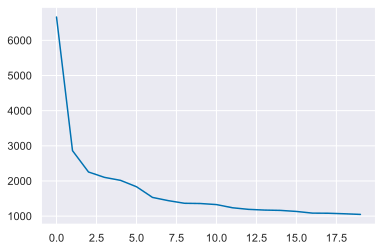

In [89]:
plt.plot(range(20), sigma)

## Collaborative-filtering ##

In [606]:
# A pairwise distance matrix must be constructed from comparing vectors of the same length
# since how would you compare the distance between a 2d vector and 100d vector, for example?
# The Euclidean distance formula looks at the squared distance between each component of the vector
user_anime_cosine_distances_collab = pairwise_distances(user_embedding_df, anime_embedding_df.T,
                                                        metric='cosine')

In [100]:
# Because user #0 (cindia) hasn't rated any movies, their user vector is the zero vector.
# The zero vector is orthogonal to any given vector since the dot product of any vector with the zero
# vector is 0. Othogonal vectors have a cosine (similarity) of 0, hence their cosine distance is 1.
# Recall that cosine distance = 1 - cosine similarity.
user_anime_cosine_distances[0]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [178]:
user_anime_cosine_distances[1]

array([0.41521695, 0.60589336, 0.74466103, 0.06051116, 0.78058344,
       0.64508188, 0.92497655, 0.72011133, 0.80824002, 0.86460689,
       0.86455373, 0.81143648, 0.84279227, 0.49102361, 0.73666146,
       0.87419654, 0.30871459, 0.81222765, 0.88994233, 0.66441345,
       0.81342038, 0.86258862, 0.7872985 , 0.63366584, 0.90735675,
       0.02108731, 0.81358691, 0.80387686, 0.76256601, 0.8310897 ,
       0.34850591, 0.36033888, 0.52796553, 0.0190716 , 0.92497655,
       0.2977071 , 0.01682228, 0.30796719, 0.92497655, 0.07461926,
       0.8894476 , 0.12663516, 0.92532992, 0.08498119, 0.42308328,
       0.85109935, 0.69154013, 0.88069355, 0.57755024, 0.91565109,
       0.82648331, 0.36096804, 0.76024165, 0.40485154, 0.45542987,
       0.77170188, 0.23310258, 0.81340654, 0.89792394, 0.63986017,
       0.1137006 , 0.78480449, 0.61268618, 0.85427914, 0.79025541,
       0.5443306 , 0.82481973, 0.86483161, 0.9098958 , 0.08053322,
       0.8110178 , 0.77564605, 0.30037776, 0.11021143, 0.89731

In [101]:
user_anime_cosine_distances.shape

(120000, 1000)

In [175]:
latent_features = ['Popular',
                   'Action-packed classics',
                   'Supernatural/fantasy',
                   'Shounen',
                   'Slice-of-life/school',
                   'Artsy classics']

In [176]:
# Naming my latent features for ease
user_embedding_df.columns = latent_features                         

In [177]:
user_embedding_df.head()

,Popular,Action-packed classics,Supernatural/fantasy,Shounen,Slice-of-life/school,Artsy classics
0,0.00,0.00,0.00,0.00,0.00,0.00
1,0.03,0.38,0.07,0.09,0.00,0.04
2,0.00,0.14,0.03,0.13,0.00,0.00
3,0.00,0.63,0.00,0.36,0.00,0.00
4,0.11,0.22,0.10,0.27,0.04,0.33


Create a function to get the top X collaborative-filtering recommendations and filter out anime that are already in the user's animelist

In [554]:
reload(rec)

<module 'recommender' from './../src/recommender.py'>

In [555]:
%%time
rec.get_collab_filt_recs('cindia', user_anime_cosine_distances,
                         anime_titles, user_score_df)

CPU times: user 13.8 s, sys: 40.6 ms, total: 13.9 s
Wall time: 13.9 s


['Fullmetal Alchemist: Brotherhood',
 'Suzumiya Haruhi no Yuuutsu',
 'Top wo Nerae! Gunbuster',
 'Uchouten Kazoku',
 'Planetarian: Hoshi no Hito',
 'Vampire Hunter D (2000)',
 "Working'!!",
 'Yuru Yuri Nachuyachumi!',
 'Akachan to Boku',
 'Coquelicot-zaka kara']

## Content-based filtering feature engineering ##
1. May need to do PCA if I have too many features to make sure my distance calculations are as meaningful as possible since apparently even cosine similarity can suffer from the curse of dimensionality since the chance of vectors being orthogonal increase as the dimensions increase per [this post](https://stats.stackexchange.com/questions/341535/curse-of-dimensionality-does-cosine-similarity-work-better-and-if-so-why#:~:text=It%20is%20easy%20to%20see,on%20a%20999%20dimensional%20space).

In [417]:
with open('../pickles/cleaned_top_anime_data_1000_df.pkl', 'rb') as read_file:
    top_anime_df = pickle.load(read_file)

In [418]:
# Create dummy variables for categorical columns and join with original df
top_anime_df = top_anime_df.join(pd.get_dummies(top_anime_df['media_type'], drop_first=True))

top_anime_df = top_anime_df.join(pd.get_dummies(top_anime_df['content_rating'], drop_first=True))

top_anime_df = top_anime_df.join(pd.get_dummies(top_anime_df['airing_status'], drop_first=True))

In [419]:
unique_genres = {genre for genre_list in top_anime_df['genres'].value_counts().index.to_list() 
                 for genre in genre_list}

In [420]:
# Create genre encodings (an anime can have multiple genres)
for genre in unique_genres:
    top_anime_df[genre] = top_anime_df.apply(lambda x: genre in x['genres'], axis=1).astype(int)

**Decided not to include studios as a feature in my recommender since it adds too many dimensions, most of which are meaningless.**

In [379]:
# Decided not to include studios as a feature in my recommender since it adds too many dimensions, most
# of which are meaningless
# unique_studios = {studio for studio_list in top_anime_df['studios'].value_counts().index.to_list()
#                   for studio in studio_list}

In [380]:
# for studio in unique_studios:
#     top_anime_df[studio] = top_anime_df.apply(lambda x: studio in x['studios'], axis=1).astype(int)

In [423]:
cols_to_drop = ['mal_id',
                'url',
                'image_url',
                'trailer_url',
                'title_main',
                'title_english',
                'media_type',
                'source_material',
                'airing_status',
                'aired_dates',
                'premiered',
                'duration',
                'content_rating',
                'genres',
                'scored_by_num_users',
                'rank_score',
                'rank_popularity',
                'favorites',
                'studios',
                'producers',
                'licensors',
                'aired_from',
                'aired_to']

In [424]:
# Drop all non-relevant features for content-based filtering
top_anime_df_core = top_anime_df.drop(columns=cols_to_drop)

In [556]:
top_anime_df_core.shape

(1000, 54)

In [578]:
top_anime_df.head()

,mal_id,url,image_url,trailer_url,title_main,title_english,media_type,source_material,num_episodes,airing_status,aired_dates,premiered,duration,content_rating,genres,score,scored_by_num_users,rank_score,rank_popularity,members,favorites,studios,producers,licensors,aired_from,aired_to,age_in_years,Music,ONA,OVA,Special,TV,None,PG - Children,PG-13 - Teens 13 or older,R - 17+ (violence & profanity),R+ - Mild Nudity,Finished Airing,Police,Slice of Life,Shounen Ai,Psychological,Demons,Vampire,Martial Arts,Dementia,Historical,Supernatural,Sports,Romance,Shoujo,Cars,Shoujo Ai,Seinen,Fantasy,Ecchi,Shounen,Military,Super Power,Space,Mystery,Mecha,Kids,Harem,Parody,Thriller,Drama,Game,Josei,School,Comedy,Action,Horror,Sci-Fi,Magic,Samurai,Adventure
0,5114,https://myanimelist.net/anime/5114,https://cdn.myanimelist.net/images/anime/1223/...,https://www.youtube.com/embed/--IcmZkvL0Q?enab...,Fullmetal Alchemist: Brotherhood,Fullmetal Alchemist: Brotherhood,TV,Manga,64,Finished Airing,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,24 min. per ep.,R - 17+ (violence & profanity),"[Action, Military, Adventure, Comedy, Drama, M...",9.22,1174592,1,4,1927055,161405,[Bones],"[Aniplex, Square Enix, Mainichi Broadcasting S...","[Funimation, Aniplex of America]",2009-04-05,"Jul 4, 2010",11.59,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,1
1,9253,https://myanimelist.net/anime/9253,https://cdn.myanimelist.net/images/anime/5/731...,https://www.youtube.com/embed/27OZc-ku6is?enab...,Steins;Gate,Steins;Gate,TV,Visual novel,24,Finished Airing,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,24 min. per ep.,PG-13 - Teens 13 or older,"[Thriller, Sci-Fi]",9.13,852597,2,8,1563592,134539,[White Fox],"[Frontier Works, Media Factory, Movic, AT-X, K...",[Funimation],2011-04-06,"Sep 14, 2011",9.56,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
2,11061,https://myanimelist.net/anime/11061,https://cdn.myanimelist.net/images/anime/11/33...,https://www.youtube.com/embed/D9iTQRB4XRk?enab...,Hunter x Hunter (2011),Hunter x Hunter,TV,Manga,148,Finished Airing,"Oct 2, 2011 to Sep 24, 2014",Fall 2011,23 min. per ep.,PG-13 - Teens 13 or older,"[Action, Adventure, Fantasy, Shounen, Super Po...",9.12,770127,3,15,1350919,121281,[Madhouse],"[VAP, Nippon Television Network, Shueisha]",[Viz Media],2011-10-02,"Sep 24, 2014",9.06,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,820,https://myanimelist.net/anime/820,https://cdn.myanimelist.net/images/anime/13/13...,https://www.youtube.com/embed/G7grjXe2Eyo?enab...,Ginga Eiyuu Densetsu,Legend of the Galactic Heroes,OVA,Novel,110,Finished Airing,"Jan 8, 1988 to Mar 17, 1997","Jan 8, 1988",26 min. per ep.,R - 17+ (violence & profanity),"[Military, Sci-Fi, Space, Drama]",9.10,46106,5,623,203416,12645,"[Artland, Magic Bus]","[Kitty Films, K-Factory]",[Sentai Filmworks],1988-01-08,"Mar 17, 1997",33.14,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,28977,https://myanimelist.net/anime/28977,https://cdn.myanimelist.net/images/anime/3/720...,None,Gintama°,Gintama Season 4,TV,Manga,51,Finished Airing,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,24 min. per ep.,PG-13 - Teens 13 or older,"[Action, Comedy, Historical, Parody, Samurai, ...",9.11,119965,4,334,343076,9473,[Bandai Namco Pictures],"[TV Tokyo, Aniplex, Dentsu]","[Funimation, Crunchyroll]",2015-04-08,"Mar 30, 2016",5.50,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0


## Content-based filtering with dimensionality reduction (PCA) ##

In [425]:
# Scale features to unit standard deviation (no mean centering, since PCA does it automatically)
scaler = StandardScaler(with_mean=False, with_std=True)
top_anime_df_core_scaled = scaler.fit_transform(top_anime_df_core)

In [431]:
# Create PCA of top 1000 anime with 25 components 
# 25 components chosen to get 71% of variance explained
pca = PCA(n_components=25, random_state=4444)
top_anime_pca = pca.fit_transform(top_anime_df_core_scaled)

In [434]:
top_anime_pca.shape

(1000, 25)

In [451]:
top_anime_pca_df = pd.DataFrame(top_anime_pca).T
top_anime_pca_df.columns = anime_titles

In [454]:
top_anime_pca_df.head()

,Fullmetal Alchemist: Brotherhood,Steins;Gate,Hunter x Hunter (2011),Ginga Eiyuu Densetsu,Gintama°,Gintama',Shingeki no Kyojin Season 3 Part 2,Gintama': Enchousen,3-gatsu no Lion 2nd Season,Kimi no Na wa.,Koe no Katachi,Gintama.,Clannad: After Story,Gintama,Gintama Movie 2: Kanketsu-hen - Yorozuya yo Eien Nare,Owarimonogatari 2nd Season,Code Geass: Hangyaku no Lelouch R2,Haikyuu!!: Karasuno Koukou vs. Shiratorizawa Gakuen Koukou,Mob Psycho 100 II,Sen to Chihiro no Kamikakushi,Gintama.: Shirogane no Tamashii-hen - Kouhan-sen,Kaguya-sama wa Kokurasetai?: Tensai-tachi no Renai Zunousen,Kizumonogatari III: Reiketsu-hen,Shouwa Genroku Rakugo Shinjuu: Sukeroku Futatabi-hen,Shigatsu wa Kimi no Uso,Cowboy Bebop,Gintama.: Shirogane no Tamashii-hen,Haikyuu!! Second Season,Made in Abyss,Monogatari Series: Second Season,Mushishi Zoku Shou 2nd Season,Hajime no Ippo,Mononoke Hime,Rurouni Kenshin: Meiji Kenkaku Romantan - Tsuioku-hen,Vinland Saga,Code Geass: Hangyaku no Lelouch,Monster,Mushishi Zoku Shou,Made in Abyss Movie 3: Fukaki Tamashii no Reimei,Great Teacher Onizuka,Kimetsu no Yaiba,Mushishi,Seishun Buta Yarou wa Yumemiru Shoujo no Yume wo Minai,Tengen Toppa Gurren Lagann,Hajime no Ippo: New Challenger,Natsume Yuujinchou Shi,Howl no Ugoku Shiro,Ookami Kodomo no Ame to Yuki,Suzumiya Haruhi no Shoushitsu,Yakusoku no Neverland,Natsume Yuujinchou Roku,Ashita no Joe 2,JoJo no Kimyou na Bouken Part 5: Ougon no Kaze,Mushishi Zoku Shou: Suzu no Shizuku,Death Note,Kizumonogatari II: Nekketsu-hen,Ping Pong the Animation,One Punch Man,Violet Evergarden,Shouwa Genroku Rakugo Shinjuu,Yojouhan Shinwa Taikei,Fate/stay night Movie: Heaven's Feel - II. Lost Butterfly,Hajime no Ippo: Rising,Natsume Yuujinchou San,Bakuman. 3rd Season,Fate/Zero 2nd Season,Natsume Yuujinchou Go,Kimi no Suizou wo Tabetai,Sora yori mo Tooi Basho,Tengen Toppa Gurren Lagann Movie 2: Lagann-hen,Zoku Natsume Yuujinchou,Haikyuu!!,Mushishi: Hihamukage,Kara no Kyoukai 5: Mujun Rasen,Kono Subarashii Sekai ni Shukufuku wo!: Kurenai Densetsu,Ansatsu Kyoushitsu 2nd Season,Aria the Origination,Chihayafuru 3,Koukaku Kidoutai: Stand Alone Complex 2nd GIG,Gintama.: Porori-hen,JoJo no Kimyou na Bouken Part 4: Diamond wa Kudakenai,Rainbow: Nisha Rokubou no Shichinin,Slam Dunk,Uchuu Kyoudai,Saiki Kusuo no Ψ-nan 2,Steins;Gate 0,Gintama Movie 1: Shinyaku Benizakura-hen,Hotaru no Haka,Mo Dao Zu Shi,Neon Genesis Evangelion: The End of Evangelion,Shingeki no Kyojin Season 3,Steins;Gate Movie: Fuka Ryouiki no Déjà vu,Samurai Champloo,Kingdom 3rd Season,Mob Psycho 100,JoJo no Kimyou na Bouken Part 3: Stardust Crusaders 2nd Season,Nichijou,Re:Zero kara Hajimeru Isekai Seikatsu 2nd Season,Yahari Ore no Seishun Love Comedy wa Machigatteiru. Kan,One Piece,Saiki Kusuo no Ψ-nan,Tenki no Ko,Kaze ga Tsuyoku Fuiteiru,Kenpuu Denki Berserk,Major S5,Mushishi Zoku Shou: Odoro no Michi,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.,Chihayafuru 2,Cross Game,Haikyuu!!: To the Top,Kara no Kyoukai 7: Satsujin Kousatsu (Go),Koukaku Kidoutai: Stand Alone Complex,Nana,Owarimonogatari,Sayonara no Asa ni Yakusoku no Hana wo Kazarou,Usagi Drop,Yuu☆Yuu☆Hakusho,Shingeki no Kyojin,3-gatsu no Lion,Boku no Hero Academia 2nd Season,Kaguya-sama wa Kokurasetai: Tensai-tachi no Renai Zunousen,Kono Oto Tomare! 2nd Season,Mahou Shoujo Madoka★Magica Movie 3: Hangyaku no Monogatari,Gintama: Yorinuki Gintama-san on Theater 2D,Hunter x Hunter,Kiseijuu: Sei no Kakuritsu,Perfect Blue,Violet Evergarden Gaiden: Eien to Jidou Shuki Ningyou,Baccano!,Bakuman. 2nd Season,Barakamon,Gintama°: Aizome Kaori-hen,Hellsing Ultimate,Hotarubi no Mori e,Houseki no Kuni (TV),Kaze no Tani no Nausicaä,Mononoke,Boku dake ga Inai Machi,Kingdom 2nd Season,Kizumonogatari I: Tekketsu-hen,Mo Dao Zu Shi 2nd Season,Natsume Yuujinchou Movie: Utsusemi ni Musubu,Natsume Yuujinchou Roku Specials,Grand Blue,Kamisama Hajimemashita: Kako-hen,No Game No Life: Zero,Psycho-Pass,Seishun Buta Yarou wa Bunny Girl Senpai no Yume wo Minai,Shingeki no Kyojin Season 2,Uc

### Now I need to create a matrix of user vectors that are averages of the anime that they've watched. ###
1. I will need to use **cosine distance** to capture the relationship between the user vector and anime vector regardless of the magnitudes of the vectors. Since the anime and user vectors have different magnitudes, Euclidean distances can give spurious relationships based on proximity of vector endpoints. For example, Euclidean distance may recommend a user who watches shounen anime a non-shounen anime because a non-shounen anime can happen to be closer to the user vector based on Euclidean distance.  
2. Make the user vector an average of the anime PCA vectors that the user has watched. 

In [440]:
user_anime_history_df = user_score_df.drop(columns=['user_id', 'animelist_url'])

In [524]:
# Create user vectors that are an average of the anime PCA vectors that the user has rated
user_vectors = np.zeros((0, 25))
for _, row in tqdm(user_anime_history_df.iterrows()):
    # If there is at least one non-zero score, then proceed with adding PCA components of
    # anime with non-zero scores to user_vector
    if row.any():
        # Initialize the user_vector as an empty 2d array with 25 columns
        user_vector = np.zeros((0, 25))
        for i in range(len(row)):
            if row[i] != 0:
                user_vector = np.concatenate(
                    (user_vector,
                     top_anime_pca_df[row.index[i]].values.reshape(1, 25)),
                    axis=0)
        # Take average of PCA components for each anime user has rated
        # (which indicates user has watched the anime)
        user_vector = user_vector.mean(axis=0).reshape(1, 25)
        user_vectors = np.concatenate((user_vectors, user_vector), axis=0)
    else:
        user_vectors = np.concatenate(
            (user_vectors, np.zeros((1, 25))), axis=0)

120000it [19:31, 102.40it/s]


In [525]:
user_vectors.shape

(120000, 25)

In [526]:
user_vector_pca_df = pd.DataFrame(user_vectors)

In [ ]:
with open(f'../pickles/user_vector_pca_df.pkl', 'wb') as to_write:
    pickle.dump(user_vector_pca_df, to_write)

In [541]:
user_vector_pca_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.61,-0.81,0.99,0.26,-0.36,-0.94,0.91,-0.44,0.06,-0.44,-0.25,-0.11,-0.10,-0.07,0.02,0.27,0.06,-0.10,0.16,0.09,-0.28,-0.11,0.18,-0.05,-0.09
2,2.58,-1.68,0.10,1.53,-0.82,-0.65,-0.76,-0.25,-0.20,0.52,0.36,-0.96,-0.05,0.42,0.41,-0.33,0.83,0.19,0.00,0.10,-0.24,0.38,0.29,-0.36,0.28
3,0.44,-0.29,0.10,1.44,-0.54,-0.67,0.38,0.18,0.17,0.30,-0.15,-0.33,0.11,0.07,0.10,0.07,0.05,0.12,-0.10,-0.10,0.13,0.07,0.16,0.11,-0.04
4,0.17,-0.52,0.37,0.81,0.16,0.14,0.28,-0.54,-0.08,-0.38,0.28,0.30,0.20,0.40,0.06,0.13,0.10,0.15,-0.17,0.16,-0.02,0.39,-0.05,-0.05,-0.01


In [529]:
user_anime_pca_cosine_distances = pairwise_distances(user_vector_pca_df, top_anime_pca_df.T,
                                                     metric='cosine')

In [531]:
user_anime_pca_cosine_distances.shape

(120000, 1000)

In [560]:
reload(rec)

<module 'recommender' from './../src/recommender.py'>

In [562]:
%%time
# Cosine distances
rec.get_content_filt_recs('Yuber', user_anime_pca_cosine_distances,
                         anime_titles, user_score_df)

CPU times: user 14.2 s, sys: 81.2 ms, total: 14.2 s
Wall time: 14.3 s


['Pandora Hearts',
 'Tonari no Totoro',
 'City Hunter 2',
 'Trigun',
 'City Hunter',
 'Fairy Tail',
 'Hunter x Hunter',
 'Bleach',
 'City Hunter 3',
 'Detective Conan Movie 15: Quarter of Silence']

## Content-based filtering w/o dimensionality reduction ##

In [565]:
with open('../pickles/user_anime_history_df.pkl', 'rb') as read_file:
    user_anime_history_df = pickle.load(read_file)

In [569]:
user_anime_history_df_core = user_anime_history_df.drop(columns=['user_id', 'animelist_url'])

In [588]:
top_anime_df_core.T.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
num_episodes,64.00,24.00,148.00,110.00,51.00,51.00,10.00,13.00,22.00,1.00,1.00,12.00,24.00,201.00,1.00,7.00,2

In [573]:
top_anime_df_core.shape

(1000, 54)

In [570]:
user_anime_history_df_core.head(1)

,Fullmetal Alchemist: Brotherhood,Steins;Gate,Hunter x Hunter (2011),Ginga Eiyuu Densetsu,Gintama°,Gintama',Shingeki no Kyojin Season 3 Part 2,Gintama': Enchousen,3-gatsu no Lion 2nd Season,Kimi no Na wa.,Koe no Katachi,Gintama.,Clannad: After Story,Gintama,Gintama Movie 2: Kanketsu-hen - Yorozuya yo Eien Nare,Owarimonogatari 2nd Season,Code Geass: Hangyaku no Lelouch R2,Haikyuu!!: Karasuno Koukou vs. Shiratorizawa Gakuen Koukou,Mob Psycho 100 II,Sen to Chihiro no Kamikakushi,Gintama.: Shirogane no Tamashii-hen - Kouhan-sen,Kaguya-sama wa Kokurasetai?: Tensai-tachi no Renai Zunousen,Kizumonogatari III: Reiketsu-hen,Shouwa Genroku Rakugo Shinjuu: Sukeroku Futatabi-hen,Shigatsu wa Kimi no Uso,Cowboy Bebop,Gintama.: Shirogane no Tamashii-hen,Haikyuu!! Second Season,Made in Abyss,Monogatari Series: Second Season,Mushishi Zoku Shou 2nd Season,Hajime no Ippo,Mononoke Hime,Rurouni Kenshin: Meiji Kenkaku Romantan - Tsuioku-hen,Vinland Saga,Code Geass: Hangyaku no Lelouch,Monster,Mushishi Zoku Shou,Made in Abyss Movie 3: Fukaki Tamashii no Reimei,Great Teacher Onizuka,Kimetsu no Yaiba,Mushishi,Seishun Buta Yarou wa Yumemiru Shoujo no Yume wo Minai,Tengen Toppa Gurren Lagann,Hajime no Ippo: New Challenger,Natsume Yuujinchou Shi,Howl no Ugoku Shiro,Ookami Kodomo no Ame to Yuki,Suzumiya Haruhi no Shoushitsu,Yakusoku no Neverland,Natsume Yuujinchou Roku,Ashita no Joe 2,JoJo no Kimyou na Bouken Part 5: Ougon no Kaze,Mushishi Zoku Shou: Suzu no Shizuku,Death Note,Kizumonogatari II: Nekketsu-hen,Ping Pong the Animation,One Punch Man,Violet Evergarden,Shouwa Genroku Rakugo Shinjuu,Yojouhan Shinwa Taikei,Fate/stay night Movie: Heaven's Feel - II. Lost Butterfly,Hajime no Ippo: Rising,Natsume Yuujinchou San,Bakuman. 3rd Season,Fate/Zero 2nd Season,Natsume Yuujinchou Go,Kimi no Suizou wo Tabetai,Sora yori mo Tooi Basho,Tengen Toppa Gurren Lagann Movie 2: Lagann-hen,Zoku Natsume Yuujinchou,Haikyuu!!,Mushishi: Hihamukage,Kara no Kyoukai 5: Mujun Rasen,Kono Subarashii Sekai ni Shukufuku wo!: Kurenai Densetsu,Ansatsu Kyoushitsu 2nd Season,Aria the Origination,Chihayafuru 3,Koukaku Kidoutai: Stand Alone Complex 2nd GIG,Gintama.: Porori-hen,JoJo no Kimyou na Bouken Part 4: Diamond wa Kudakenai,Rainbow: Nisha Rokubou no Shichinin,Slam Dunk,Uchuu Kyoudai,Saiki Kusuo no Ψ-nan 2,Steins;Gate 0,Gintama Movie 1: Shinyaku Benizakura-hen,Hotaru no Haka,Mo Dao Zu Shi,Neon Genesis Evangelion: The End of Evangelion,Shingeki no Kyojin Season 3,Steins;Gate Movie: Fuka Ryouiki no Déjà vu,Samurai Champloo,Kingdom 3rd Season,Mob Psycho 100,JoJo no Kimyou na Bouken Part 3: Stardust Crusaders 2nd Season,Nichijou,Re:Zero kara Hajimeru Isekai Seikatsu 2nd Season,Yahari Ore no Seishun Love Comedy wa Machigatteiru. Kan,One Piece,Saiki Kusuo no Ψ-nan,Tenki no Ko,Kaze ga Tsuyoku Fuiteiru,Kenpuu Denki Berserk,Major S5,Mushishi Zoku Shou: Odoro no Michi,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.,Chihayafuru 2,Cross Game,Haikyuu!!: To the Top,Kara no Kyoukai 7: Satsujin Kousatsu (Go),Koukaku Kidoutai: Stand Alone Complex,Nana,Owarimonogatari,Sayonara no Asa ni Yakusoku no Hana wo Kazarou,Usagi Drop,Yuu☆Yuu☆Hakusho,Shingeki no Kyojin,3-gatsu no Lion,Boku no Hero Academia 2nd Season,Kaguya-sama wa Kokurasetai: Tensai-tachi no Renai Zunousen,Kono Oto Tomare! 2nd Season,Mahou Shoujo Madoka★Magica Movie 3: Hangyaku no Monogatari,Gintama: Yorinuki Gintama-san on Theater 2D,Hunter x Hunter,Kiseijuu: Sei no Kakuritsu,Perfect Blue,Violet Evergarden Gaiden: Eien to Jidou Shuki Ningyou,Baccano!,Bakuman. 2nd Season,Barakamon,Gintama°: Aizome Kaori-hen,Hellsing Ultimate,Hotarubi no Mori e,Houseki no Kuni (TV),Kaze no Tani no Nausicaä,Mononoke,Boku dake ga Inai Machi,Kingdom 2nd Season,Kizumonogatari I: Tekketsu-hen,Mo Dao Zu Shi 2nd Season,Natsume Yuujinchou Movie: Utsusemi ni Musubu,Natsume Yuujinchou Roku Specials,Grand Blue,Kamisama Hajimemashita: Kako-hen,No Game No Life: Zero,Psycho-Pass,Seishun Buta Yarou wa Bunny Girl Senpai no Yume wo Minai,Shingeki no Kyojin Season 2,Uc

In [601]:
top_anime_df_core.shape

(1000, 54)

In [587]:
user_anime_history_df_core.head()

,Fullmetal Alchemist: Brotherhood,Steins;Gate,Hunter x Hunter (2011),Ginga Eiyuu Densetsu,Gintama°,Gintama',Shingeki no Kyojin Season 3 Part 2,Gintama': Enchousen,3-gatsu no Lion 2nd Season,Kimi no Na wa.,Koe no Katachi,Gintama.,Clannad: After Story,Gintama,Gintama Movie 2: Kanketsu-hen - Yorozuya yo Eien Nare,Owarimonogatari 2nd Season,Code Geass: Hangyaku no Lelouch R2,Haikyuu!!: Karasuno Koukou vs. Shiratorizawa Gakuen Koukou,Mob Psycho 100 II,Sen to Chihiro no Kamikakushi,Gintama.: Shirogane no Tamashii-hen - Kouhan-sen,Kaguya-sama wa Kokurasetai?: Tensai-tachi no Renai Zunousen,Kizumonogatari III: Reiketsu-hen,Shouwa Genroku Rakugo Shinjuu: Sukeroku Futatabi-hen,Shigatsu wa Kimi no Uso,Cowboy Bebop,Gintama.: Shirogane no Tamashii-hen,Haikyuu!! Second Season,Made in Abyss,Monogatari Series: Second Season,Mushishi Zoku Shou 2nd Season,Hajime no Ippo,Mononoke Hime,Rurouni Kenshin: Meiji Kenkaku Romantan - Tsuioku-hen,Vinland Saga,Code Geass: Hangyaku no Lelouch,Monster,Mushishi Zoku Shou,Made in Abyss Movie 3: Fukaki Tamashii no Reimei,Great Teacher Onizuka,Kimetsu no Yaiba,Mushishi,Seishun Buta Yarou wa Yumemiru Shoujo no Yume wo Minai,Tengen Toppa Gurren Lagann,Hajime no Ippo: New Challenger,Natsume Yuujinchou Shi,Howl no Ugoku Shiro,Ookami Kodomo no Ame to Yuki,Suzumiya Haruhi no Shoushitsu,Yakusoku no Neverland,Natsume Yuujinchou Roku,Ashita no Joe 2,JoJo no Kimyou na Bouken Part 5: Ougon no Kaze,Mushishi Zoku Shou: Suzu no Shizuku,Death Note,Kizumonogatari II: Nekketsu-hen,Ping Pong the Animation,One Punch Man,Violet Evergarden,Shouwa Genroku Rakugo Shinjuu,Yojouhan Shinwa Taikei,Fate/stay night Movie: Heaven's Feel - II. Lost Butterfly,Hajime no Ippo: Rising,Natsume Yuujinchou San,Bakuman. 3rd Season,Fate/Zero 2nd Season,Natsume Yuujinchou Go,Kimi no Suizou wo Tabetai,Sora yori mo Tooi Basho,Tengen Toppa Gurren Lagann Movie 2: Lagann-hen,Zoku Natsume Yuujinchou,Haikyuu!!,Mushishi: Hihamukage,Kara no Kyoukai 5: Mujun Rasen,Kono Subarashii Sekai ni Shukufuku wo!: Kurenai Densetsu,Ansatsu Kyoushitsu 2nd Season,Aria the Origination,Chihayafuru 3,Koukaku Kidoutai: Stand Alone Complex 2nd GIG,Gintama.: Porori-hen,JoJo no Kimyou na Bouken Part 4: Diamond wa Kudakenai,Rainbow: Nisha Rokubou no Shichinin,Slam Dunk,Uchuu Kyoudai,Saiki Kusuo no Ψ-nan 2,Steins;Gate 0,Gintama Movie 1: Shinyaku Benizakura-hen,Hotaru no Haka,Mo Dao Zu Shi,Neon Genesis Evangelion: The End of Evangelion,Shingeki no Kyojin Season 3,Steins;Gate Movie: Fuka Ryouiki no Déjà vu,Samurai Champloo,Kingdom 3rd Season,Mob Psycho 100,JoJo no Kimyou na Bouken Part 3: Stardust Crusaders 2nd Season,Nichijou,Re:Zero kara Hajimeru Isekai Seikatsu 2nd Season,Yahari Ore no Seishun Love Comedy wa Machigatteiru. Kan,One Piece,Saiki Kusuo no Ψ-nan,Tenki no Ko,Kaze ga Tsuyoku Fuiteiru,Kenpuu Denki Berserk,Major S5,Mushishi Zoku Shou: Odoro no Michi,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.,Chihayafuru 2,Cross Game,Haikyuu!!: To the Top,Kara no Kyoukai 7: Satsujin Kousatsu (Go),Koukaku Kidoutai: Stand Alone Complex,Nana,Owarimonogatari,Sayonara no Asa ni Yakusoku no Hana wo Kazarou,Usagi Drop,Yuu☆Yuu☆Hakusho,Shingeki no Kyojin,3-gatsu no Lion,Boku no Hero Academia 2nd Season,Kaguya-sama wa Kokurasetai: Tensai-tachi no Renai Zunousen,Kono Oto Tomare! 2nd Season,Mahou Shoujo Madoka★Magica Movie 3: Hangyaku no Monogatari,Gintama: Yorinuki Gintama-san on Theater 2D,Hunter x Hunter,Kiseijuu: Sei no Kakuritsu,Perfect Blue,Violet Evergarden Gaiden: Eien to Jidou Shuki Ningyou,Baccano!,Bakuman. 2nd Season,Barakamon,Gintama°: Aizome Kaori-hen,Hellsing Ultimate,Hotarubi no Mori e,Houseki no Kuni (TV),Kaze no Tani no Nausicaä,Mononoke,Boku dake ga Inai Machi,Kingdom 2nd Season,Kizumonogatari I: Tekketsu-hen,Mo Dao Zu Shi 2nd Season,Natsume Yuujinchou Movie: Utsusemi ni Musubu,Natsume Yuujinchou Roku Specials,Grand Blue,Kamisama Hajimemashita: Kako-hen,No Game No Life: Zero,Psycho-Pass,Seishun Buta Yarou wa Bunny Girl Senpai no Yume wo Minai,Shingeki no Kyojin Season 2,Uc

In [589]:
# Create user vectors that are an average of the anime vectors that the user has rated
# (no dimensionality reduction)
num_features = top_anime_df_core.T.shape[0]
user_vectors = np.zeros((0, num_features))
for _, row in tqdm(user_anime_history_df_core.iterrows()):
    # If there is at least one non-zero entry, then add features of all anime corresponding 
    # to non-zero entries to user_vector
    if row.any():
        # Initialize the user_vector as an empty 2d array where columns equals num_features
        user_vector = np.zeros((0, num_features))
#         print(len(row))
#         print(row[0])
        for i in range(len(row)):
            if row[i] != 0:
                user_vector = np.concatenate(
                    (user_vector,
                     top_anime_df_core.T[i].values.reshape(1, num_features)),
                    axis=0)
        # Take average of features for each anime user has on their animelist
        user_vector = user_vector.mean(axis=0).reshape(1, num_features)
        user_vectors = np.concatenate((user_vectors, user_vector), axis=0)
    else:
        # If user has all zero entries (meaning user does not have
        # any of the top 1000 anime in their animelist), add a feature vector of all zeros 
        # for that user
        user_vectors = np.concatenate(
            (user_vectors, np.zeros((1, num_features))), axis=0)

120000it [52:39, 37.98it/s]


In [593]:
user_vector_df = pd.DataFrame(user_vectors)

In [596]:
# Set the columns to the anime feature names
user_vector_df.columns = top_anime_df_core.columns

In [599]:
with open(f'../pickles/user_vector_df.pkl', 'wb') as to_write:
    pickle.dump(user_vector_df, to_write)

In [604]:
user_anime_cosine_distances_content = pairwise_distances(user_vector_df, top_anime_df_core,
                                                         metric='cosine')

## Making final recommendations ##

**Need to decide how many recommendations I want to show: 5 or 10? Leaning toward 5 recommendations because screen will be less crowded and then a weight of 2 will give all collaborative recommendations, which make the recommendations symmetrical around the weights (0 = all content-based recs, 1 = mix, 2 = all collab recs).**

In [663]:
# Need to decide how many recommendations I want to show: 5 or 10? 
# Leaning toward 5 recommendations because screen will be less crowded 
# and then a weight of 2 will give all collaborative recommendations, 
# which make the recommendations symmetrical around the weights (0 = all)
bellico_rec_score_df.sort_values('weighted_score', ascending=False, ignore_index=True)

,user_id,anime_rec,rec_type,original_rank,base_score,weighted_score
0,bellico,Bakuman.,content,1,10,10
1,bellico,K-On!!,content,2,9,9
2,bellico,Toaru Kagaku no Railgun,content,3,8,8
3,bellico,Shiki,content,4,7,7
4,bellico,Lucky☆Star,content,5,6,6
5,bellico,Zetsuen no Tempest,content,6,5,5
6,bellico,NHK ni Youkoso!,content,7,4,4
7,bellico,Mushishi,content,8,3,3
8,bellico,Gosick,content,9,2,2
9,bellico,Higurashi no Naku Koro ni,content,10,1,1


In [676]:
%%time
zetsuji_recs, zetsuji_recs_df = rec.recommend('Zetsuji', user_anime_cosine_distances_content,
                                              user_anime_cosine_distances_collab, user_score_df,
                                              user_anime_history_df, anime_titles)

CPU times: user 30.6 s, sys: 144 ms, total: 30.7 s
Wall time: 30.9 s


In [677]:
zetsuji_recs

['Keroro Gunsou',
 'Higurashi no Naku Koro ni',
 'Tsubasa: Tokyo Revelations',
 'Mushishi',
 'Saiyuuki Reload: Burial',
 'Kimi ni Todoke',
 'InuYasha Movie 3: Tenka Hadou no Ken',
 'Lucky☆Star',
 'Ranma ½',
 'Nichijou']

In [678]:
zetsuji_recs_df

,user_id,anime_rec,rec_type,original_rank,base_score,weighted_score
0,Zetsuji,Keroro Gunsou,collab,1,10,10
1,Zetsuji,Higurashi no Naku Koro ni,content,1,10,10
2,Zetsuji,Tsubasa: Tokyo Revelations,collab,2,9,9
3,Zetsuji,Mushishi,content,2,9,9
4,Zetsuji,Saiyuuki Reload: Burial,collab,3,8,8
5,Zetsuji,Kimi ni Todoke,content,3,8,8
6,Zetsuji,InuYasha Movie 3: Tenka Hadou no Ken,collab,4,7,7
7,Zetsuji,Lucky☆Star,content,4,7,7
8,Zetsuji,Ranma ½,collab,5,6,6
9,Zetsuji,Nichijou,content,5,6,6


In [672]:
bellico_recs

['Rurouni Kenshin: Meiji Kenkaku Romantan',
 'Bakuman.',
 'Hikaru no Go',
 'K-On!!',
 'Saint Seiya: Meiou Hades Juuni Kyuu-hen',
 'Toaru Kagaku no Railgun',
 'Fullmetal Alchemist',
 'Shiki',
 'Mobile Suit Gundam SEED',
 'Lucky☆Star']

In [674]:
user_score_df.head()

,user_id,animelist_url,Fullmetal Alchemist: Brotherhood,Steins;Gate,Hunter x Hunter (2011),Ginga Eiyuu Densetsu,Gintama°,Gintama',Shingeki no Kyojin Season 3 Part 2,Gintama': Enchousen,3-gatsu no Lion 2nd Season,Kimi no Na wa.,Koe no Katachi,Gintama.,Clannad: After Story,Gintama,Gintama Movie 2: Kanketsu-hen - Yorozuya yo Eien Nare,Owarimonogatari 2nd Season,Code Geass: Hangyaku no Lelouch R2,Haikyuu!!: Karasuno Koukou vs. Shiratorizawa Gakuen Koukou,Mob Psycho 100 II,Sen to Chihiro no Kamikakushi,Gintama.: Shirogane no Tamashii-hen - Kouhan-sen,Kaguya-sama wa Kokurasetai?: Tensai-tachi no Renai Zunousen,Kizumonogatari III: Reiketsu-hen,Shouwa Genroku Rakugo Shinjuu: Sukeroku Futatabi-hen,Shigatsu wa Kimi no Uso,Cowboy Bebop,Gintama.: Shirogane no Tamashii-hen,Haikyuu!! Second Season,Made in Abyss,Monogatari Series: Second Season,Mushishi Zoku Shou 2nd Season,Hajime no Ippo,Mononoke Hime,Rurouni Kenshin: Meiji Kenkaku Romantan - Tsuioku-hen,Vinland Saga,Code Geass: Hangyaku no Lelouch,Monster,Mushishi Zoku Shou,Made in Abyss Movie 3: Fukaki Tamashii no Reimei,Great Teacher Onizuka,Kimetsu no Yaiba,Mushishi,Seishun Buta Yarou wa Yumemiru Shoujo no Yume wo Minai,Tengen Toppa Gurren Lagann,Hajime no Ippo: New Challenger,Natsume Yuujinchou Shi,Howl no Ugoku Shiro,Ookami Kodomo no Ame to Yuki,Suzumiya Haruhi no Shoushitsu,Yakusoku no Neverland,Natsume Yuujinchou Roku,Ashita no Joe 2,JoJo no Kimyou na Bouken Part 5: Ougon no Kaze,Mushishi Zoku Shou: Suzu no Shizuku,Death Note,Kizumonogatari II: Nekketsu-hen,Ping Pong the Animation,One Punch Man,Violet Evergarden,Shouwa Genroku Rakugo Shinjuu,Yojouhan Shinwa Taikei,Fate/stay night Movie: Heaven's Feel - II. Lost Butterfly,Hajime no Ippo: Rising,Natsume Yuujinchou San,Bakuman. 3rd Season,Fate/Zero 2nd Season,Natsume Yuujinchou Go,Kimi no Suizou wo Tabetai,Sora yori mo Tooi Basho,Tengen Toppa Gurren Lagann Movie 2: Lagann-hen,Zoku Natsume Yuujinchou,Haikyuu!!,Mushishi: Hihamukage,Kara no Kyoukai 5: Mujun Rasen,Kono Subarashii Sekai ni Shukufuku wo!: Kurenai Densetsu,Ansatsu Kyoushitsu 2nd Season,Aria the Origination,Chihayafuru 3,Koukaku Kidoutai: Stand Alone Complex 2nd GIG,Gintama.: Porori-hen,JoJo no Kimyou na Bouken Part 4: Diamond wa Kudakenai,Rainbow: Nisha Rokubou no Shichinin,Slam Dunk,Uchuu Kyoudai,Saiki Kusuo no Ψ-nan 2,Steins;Gate 0,Gintama Movie 1: Shinyaku Benizakura-hen,Hotaru no Haka,Mo Dao Zu Shi,Neon Genesis Evangelion: The End of Evangelion,Shingeki no Kyojin Season 3,Steins;Gate Movie: Fuka Ryouiki no Déjà vu,Samurai Champloo,Kingdom 3rd Season,Mob Psycho 100,JoJo no Kimyou na Bouken Part 3: Stardust Crusaders 2nd Season,Nichijou,Re:Zero kara Hajimeru Isekai Seikatsu 2nd Season,Yahari Ore no Seishun Love Comedy wa Machigatteiru. Kan,One Piece,Saiki Kusuo no Ψ-nan,Tenki no Ko,Kaze ga Tsuyoku Fuiteiru,Kenpuu Denki Berserk,Major S5,Mushishi Zoku Shou: Odoro no Michi,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.,Chihayafuru 2,Cross Game,Haikyuu!!: To the Top,Kara no Kyoukai 7: Satsujin Kousatsu (Go),Koukaku Kidoutai: Stand Alone Complex,Nana,Owarimonogatari,Sayonara no Asa ni Yakusoku no Hana wo Kazarou,Usagi Drop,Yuu☆Yuu☆Hakusho,Shingeki no Kyojin,3-gatsu no Lion,Boku no Hero Academia 2nd Season,Kaguya-sama wa Kokurasetai: Tensai-tachi no Renai Zunousen,Kono Oto Tomare! 2nd Season,Mahou Shoujo Madoka★Magica Movie 3: Hangyaku no Monogatari,Gintama: Yorinuki Gintama-san on Theater 2D,Hunter x Hunter,Kiseijuu: Sei no Kakuritsu,Perfect Blue,Violet Evergarden Gaiden: Eien to Jidou Shuki Ningyou,Baccano!,Bakuman. 2nd Season,Barakamon,Gintama°: Aizome Kaori-hen,Hellsing Ultimate,Hotarubi no Mori e,Houseki no Kuni (TV),Kaze no Tani no Nausicaä,Mononoke,Boku dake ga Inai Machi,Kingdom 2nd Season,Kizumonogatari I: Tekketsu-hen,Mo Dao Zu Shi 2nd Season,Natsume Yuujinchou Movie: Utsusemi ni Musubu,Natsume Yuujinchou Roku Specials,Grand Blue,Kamisama Hajimemashita: Kako-hen,No Game No Life: Zero,Psycho-Pass,Seishun Buta Yarou wa Bunny Girl Senpai no Yume wo Minai,Shingeki

In [673]:
bellico_recs_df

,user_id,anime_rec,rec_type,original_rank,base_score,weighted_score
0,bellico,Rurouni Kenshin: Meiji Kenkaku Romantan,collab,1,10,10
1,bellico,Bakuman.,content,1,10,10
2,bellico,Hikaru no Go,collab,2,9,9
3,bellico,K-On!!,content,2,9,9
4,bellico,Saint Seiya: Meiou Hades Juuni Kyuu-hen,collab,3,8,8
5,bellico,Toaru Kagaku no Railgun,content,3,8,8
6,bellico,Fullmetal Alchemist,collab,4,7,7
7,bellico,Shiki,content,4,7,7
8,bellico,Mobile Suit Gundam SEED,collab,5,6,6
9,bellico,Lucky☆Star,content,5,6,6


## Comparing differences between collaborative and content-based recommendations ##

In [692]:
rec.get_user_anime_history('zephyr0x', user_anime_history_df)

{'user_id': 'zephyr0x',
 'animelist_url': 'https://myanimelist.net/animelist/zephyr0x',
 'Gintama': 1,
 'Katekyo Hitman Reborn!': 1,
 'Naruto: Shippuuden': 1,
 'Naruto': 1,
 'Bleach': 1}

In [700]:
rec.get_user_scores('zephyr0x', user_score_df)

{'user_id': 'zephyr0x',
 'animelist_url': 'https://myanimelist.net/animelist/zephyr0x',
 'Gintama': 9,
 'Katekyo Hitman Reborn!': 9,
 'Naruto: Shippuuden': 7,
 'Naruto': 7,
 'Bleach': 8}

In [698]:
zephyr0x_recs, zephyr0x_recs_df = rec.recommend('zephyr0x', user_anime_cosine_distances_content,
                                                user_anime_cosine_distances_collab, user_score_df,
                                                user_anime_history_df, anime_titles)

In [715]:
alesyasabri1_recs, alesyasabri1_recs_df = rec.recommend('alesyasabri1', user_anime_cosine_distances_content,
                                                user_anime_cosine_distances_collab, user_score_df,
                                                user_anime_history_df, anime_titles)

In [716]:
alesyasabri1_recs

['Mo Dao Zu Shi',
 'Kuroko no Basket',
 'Mo Dao Zu Shi 2nd Season',
 'Akagami no Shirayuki-hime',
 'Luo Xiao Hei Zhan Ji (Movie)',
 'Kaichou wa Maid-sama!',
 'Given',
 'Clannad: After Story',
 'Udon no Kuni no Kiniro Kemari',
 '91 Days']

In [717]:
alesyasabri1_recs_df

,user_id,anime_rec,rec_type,original_rank,base_score,weighted_score
0,alesyasabri1,Mo Dao Zu Shi,collab,1,10,10
1,alesyasabri1,Kuroko no Basket,content,1,10,10
2,alesyasabri1,Mo Dao Zu Shi 2nd Season,collab,2,9,9
3,alesyasabri1,Akagami no Shirayuki-hime,content,2,9,9
4,alesyasabri1,Luo Xiao Hei Zhan Ji (Movie),collab,3,8,8
5,alesyasabri1,Kaichou wa Maid-sama!,content,3,8,8
6,alesyasabri1,Given,collab,4,7,7
7,alesyasabri1,Clannad: After Story,content,4,7,7
8,alesyasabri1,Udon no Kuni no Kiniro Kemari,collab,5,6,6
9,alesyasabri1,91 Days,content,5,6,6


In [719]:
# Normalize by dividing by sum and compare in presentation
anime_embedding_df['Mo Dao Zu Shi']

0   0.27
1   0.00
2   0.20
3   0.00
4   0.00
5   0.36
Name: Mo Dao Zu Shi, dtype: float64

In [713]:
# Normalize by dividing by sum and compare in presentation
user_embedding_df.iloc[112062]

Popular                  0.13
Action-packed classics   0.00
Supernatural/fantasy     0.09
Shounen                  0.04
Slice-of-life/school     0.02
Artsy classics           0.17
Name: 112062, dtype: float64

In [714]:
user_embedding_df.iloc[62]

Popular                  0.00
Action-packed classics   0.00
Supernatural/fantasy     0.00
Shounen                  0.18
Slice-of-life/school     0.00
Artsy classics           0.00
Name: 62, dtype: float64

In [709]:
rec.get_user_anime_history('alesyasabri1', user_anime_history_df)

40

In [710]:
rec.get_user_anime_history('alesyasabri1', user_score_df)

{'user_id': 'alesyasabri1',
 'animelist_url': 'https://myanimelist.net/animelist/alesyasabri1',
 'Haikyuu!!: Karasuno Koukou vs. Shiratorizawa Gakuen Koukou': 10,
 'Haikyuu!! Second Season': 10,
 'Haikyuu!!': 10,
 'Ansatsu Kyoushitsu 2nd Season': 9,
 'Shingeki no Kyojin': 9,
 'Shingeki no Kyojin: Kuinaki Sentaku': 9,
 'Magi: The Kingdom of Magic': 10,
 'Yahari Ore no Seishun Love Comedy wa Machigatteiru. Zoku': 10,
 'Danshi Koukousei no Nichijou': 10,
 'Noragami Aragoto': 10,
 "Kyoukai no Kanata Movie 2: I'll Be Here - Mirai-hen": 9,
 'Ouran Koukou Host Club': 10,
 'Katekyo Hitman Reborn!': 9,
 'Kuroshitsuji: Book of Circus': 9,
 'Kuroshitsuji: Book of Murder': 9,
 'Ansatsu Kyoushitsu': 9,
 'Yahari Ore no Seishun Love Comedy wa Machigatteiru. Zoku OVA': 10,
 'Magi: The Labyrinth of Magic': 10,
 'Yahari Ore no Seishun Love Comedy wa Machigatteiru.': 10,
 'Noragami': 10,
 'Free!: Eternal Summer - Kindan no All Hard!': 9,
 'Magi: Sinbad no Bouken (TV)': 9,
 'Noragami Aragoto OVA': 10,
 'H

In [705]:
user_anime_history_df.iloc[[112062]]

,user_id,animelist_url,Fullmetal Alchemist: Brotherhood,Steins;Gate,Hunter x Hunter (2011),Ginga Eiyuu Densetsu,Gintama°,Gintama',Shingeki no Kyojin Season 3 Part 2,Gintama': Enchousen,3-gatsu no Lion 2nd Season,Kimi no Na wa.,Koe no Katachi,Gintama.,Clannad: After Story,Gintama,Gintama Movie 2: Kanketsu-hen - Yorozuya yo Eien Nare,Owarimonogatari 2nd Season,Code Geass: Hangyaku no Lelouch R2,Haikyuu!!: Karasuno Koukou vs. Shiratorizawa Gakuen Koukou,Mob Psycho 100 II,Sen to Chihiro no Kamikakushi,Gintama.: Shirogane no Tamashii-hen - Kouhan-sen,Kaguya-sama wa Kokurasetai?: Tensai-tachi no Renai Zunousen,Kizumonogatari III: Reiketsu-hen,Shouwa Genroku Rakugo Shinjuu: Sukeroku Futatabi-hen,Shigatsu wa Kimi no Uso,Cowboy Bebop,Gintama.: Shirogane no Tamashii-hen,Haikyuu!! Second Season,Made in Abyss,Monogatari Series: Second Season,Mushishi Zoku Shou 2nd Season,Hajime no Ippo,Mononoke Hime,Rurouni Kenshin: Meiji Kenkaku Romantan - Tsuioku-hen,Vinland Saga,Code Geass: Hangyaku no Lelouch,Monster,Mushishi Zoku Shou,Made in Abyss Movie 3: Fukaki Tamashii no Reimei,Great Teacher Onizuka,Kimetsu no Yaiba,Mushishi,Seishun Buta Yarou wa Yumemiru Shoujo no Yume wo Minai,Tengen Toppa Gurren Lagann,Hajime no Ippo: New Challenger,Natsume Yuujinchou Shi,Howl no Ugoku Shiro,Ookami Kodomo no Ame to Yuki,Suzumiya Haruhi no Shoushitsu,Yakusoku no Neverland,Natsume Yuujinchou Roku,Ashita no Joe 2,JoJo no Kimyou na Bouken Part 5: Ougon no Kaze,Mushishi Zoku Shou: Suzu no Shizuku,Death Note,Kizumonogatari II: Nekketsu-hen,Ping Pong the Animation,One Punch Man,Violet Evergarden,Shouwa Genroku Rakugo Shinjuu,Yojouhan Shinwa Taikei,Fate/stay night Movie: Heaven's Feel - II. Lost Butterfly,Hajime no Ippo: Rising,Natsume Yuujinchou San,Bakuman. 3rd Season,Fate/Zero 2nd Season,Natsume Yuujinchou Go,Kimi no Suizou wo Tabetai,Sora yori mo Tooi Basho,Tengen Toppa Gurren Lagann Movie 2: Lagann-hen,Zoku Natsume Yuujinchou,Haikyuu!!,Mushishi: Hihamukage,Kara no Kyoukai 5: Mujun Rasen,Kono Subarashii Sekai ni Shukufuku wo!: Kurenai Densetsu,Ansatsu Kyoushitsu 2nd Season,Aria the Origination,Chihayafuru 3,Koukaku Kidoutai: Stand Alone Complex 2nd GIG,Gintama.: Porori-hen,JoJo no Kimyou na Bouken Part 4: Diamond wa Kudakenai,Rainbow: Nisha Rokubou no Shichinin,Slam Dunk,Uchuu Kyoudai,Saiki Kusuo no Ψ-nan 2,Steins;Gate 0,Gintama Movie 1: Shinyaku Benizakura-hen,Hotaru no Haka,Mo Dao Zu Shi,Neon Genesis Evangelion: The End of Evangelion,Shingeki no Kyojin Season 3,Steins;Gate Movie: Fuka Ryouiki no Déjà vu,Samurai Champloo,Kingdom 3rd Season,Mob Psycho 100,JoJo no Kimyou na Bouken Part 3: Stardust Crusaders 2nd Season,Nichijou,Re:Zero kara Hajimeru Isekai Seikatsu 2nd Season,Yahari Ore no Seishun Love Comedy wa Machigatteiru. Kan,One Piece,Saiki Kusuo no Ψ-nan,Tenki no Ko,Kaze ga Tsuyoku Fuiteiru,Kenpuu Denki Berserk,Major S5,Mushishi Zoku Shou: Odoro no Michi,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.,Chihayafuru 2,Cross Game,Haikyuu!!: To the Top,Kara no Kyoukai 7: Satsujin Kousatsu (Go),Koukaku Kidoutai: Stand Alone Complex,Nana,Owarimonogatari,Sayonara no Asa ni Yakusoku no Hana wo Kazarou,Usagi Drop,Yuu☆Yuu☆Hakusho,Shingeki no Kyojin,3-gatsu no Lion,Boku no Hero Academia 2nd Season,Kaguya-sama wa Kokurasetai: Tensai-tachi no Renai Zunousen,Kono Oto Tomare! 2nd Season,Mahou Shoujo Madoka★Magica Movie 3: Hangyaku no Monogatari,Gintama: Yorinuki Gintama-san on Theater 2D,Hunter x Hunter,Kiseijuu: Sei no Kakuritsu,Perfect Blue,Violet Evergarden Gaiden: Eien to Jidou Shuki Ningyou,Baccano!,Bakuman. 2nd Season,Barakamon,Gintama°: Aizome Kaori-hen,Hellsing Ultimate,Hotarubi no Mori e,Houseki no Kuni (TV),Kaze no Tani no Nausicaä,Mononoke,Boku dake ga Inai Machi,Kingdom 2nd Season,Kizumonogatari I: Tekketsu-hen,Mo Dao Zu Shi 2nd Season,Natsume Yuujinchou Movie: Utsusemi ni Musubu,Natsume Yuujinchou Roku Specials,Grand Blue,Kamisama Hajimemashita: Kako-hen,No Game No Life: Zero,Psycho-Pass,Seishun Buta Yarou wa Bunny Girl Senpai no Yume wo Minai,Shingeki

In [704]:
user_vector_df.iloc[[112062]]

,num_episodes,score,members,age_in_years,Music,ONA,OVA,Special,TV,None,PG - Children,PG-13 - Teens 13 or older,R - 17+ (violence & profanity),R+ - Mild Nudity,Finished Airing,Police,Slice of Life,Shounen Ai,Psychological,Demons,Vampire,Martial Arts,Dementia,Historical,Supernatural,Sports,Romance,Shoujo,Cars,Shoujo Ai,Seinen,Fantasy,Ecchi,Shounen,Military,Super Power,Space,Mystery,Mecha,Kids,Harem,Parody,Thriller,Drama,Game,Josei,School,Comedy,Action,Horror,Sci-Fi,Magic,Samurai,Adventure
112062,16.03,8.09,500046.50,6.68,0.00,0.03,0.21,0.05,0.58,0.03,0.00,0.76,0.21,0.00,1.00,0.00,0.21,0.00,0.03,0.08,0.00,0.00,0.00,0.08,0.29,0.18,0.13,0.05,0.00,0.00,0.03,0.29,0.00,0.66,0.03,0.13,0.00,0.13,0.00,0.00,0.03,0.00,0.00,0.32,0.00,0.00,0.45,0.66,0.55,0.03,0.00,0.11,0.00,0.21


In [703]:
user_vector_df[(user_vector_df['Shounen'] > 0.5) & (user_vector_df['Shounen'] < 0.7)].sample(5)

,num_episodes,score,members,age_in_years,Music,ONA,OVA,Special,TV,None,PG - Children,PG-13 - Teens 13 or older,R - 17+ (violence & profanity),R+ - Mild Nudity,Finished Airing,Police,Slice of Life,Shounen Ai,Psychological,Demons,Vampire,Martial Arts,Dementia,Historical,Supernatural,Sports,Romance,Shoujo,Cars,Shoujo Ai,Seinen,Fantasy,Ecchi,Shounen,Military,Super Power,Space,Mystery,Mecha,Kids,Harem,Parody,Thriller,Drama,Game,Josei,School,Comedy,Action,Horror,Sci-Fi,Magic,Samurai,Adventure
71403,46.35,8.41,1138633.65,7.11,0.00,0.00,0.00,0.00,0.97,0.00,0.00,0.55,0.45,0.00,1.00,0.03,0.03,0.00,0.06,0.00,0.00,0.06,0.00,0.06,0.52,0.00,0.03,0.00,0.00,0.00,0.03,0.52,0.06,0.55,0.16,0.35,0.00,0.16,0.03,0.00,0.00,0.16,0.03,0.23,0.06,0.00,0.19,0.52,0.81,0.03,0.13,0.32,0.06,0.32
63672,49.29,8.34,630039.21,13.15,0.06,0.00,0.08,0.05,0.69,0.00,0.02,0.55,0.39,0.05,1.00,0.03,0.13,0.00,0.08,0.02,0.03,0.08,0.00,0.18,0.21,0.11,0.11,0.00,0.00,0.00,0.10,0.18,0.05,0.61,0.06,0.18,0.03,0.15,0.02,0.00,0.00,0.13,0.02,0.39,0.02,0.02,0.11,0.74,0.58,0.03,0.23,0.03,0.15,0.34
63708,44.23,8.18,500789.67,14.77,0.03,0.00,0.09,0.03,0.80,0.00,0.03,0.71,0.17,0.05,0.97,0.03,0.13,0.00,0.06,0.06,0.00,0.07,0.03,0.04,0.15,0.17,0.19,0.03,0.00,0.00,0.04,0.30,0.02,0.51,0.15,0.18,0.10,0.10,0.10,0.01,0.00,0.03,0.02,0.42,0.02,0.00,0.14,0.50,0.50,0.02,0.25,0.07,0.03,0.37
112062,16.03,8.09,500046.50,6.68,0.00,0.03,0.21,0.05,0.58,0.03,0.00,0.76,0.21,0.00,1.00,0.00,0.21,0.00,0.03,0.08,0.00,0.00,0.00,0.08,0.29,0.18,0.13,0.05,0.00,0.00,0.03,0.29,0.00,0.66,0.03,0.13,0.00,0.13,0.00,0.00,0.03,0.00,0.00,0.32,0.00,0.00,0.45,0.66,0.55,0.03,0.00,0.11,0.00,0.21
44286,45.50,8.20,497712.83,18.82,0.11,0.00,0.06,0.00,0.89,0.00,0.06,0.72,0.17,0.06,0.94,0.06,0.22,0.00,0.11,0.17,0.00,0.11,0.06,0.00,0.17,0.00,0.22,0.11,0.00,0.00,0.06,0.22,0.00,0.56,0.06,0.22,0.00,0.06,0.11,0.00,0.00,0.06,0.06,0.56,0.00,0.06,0.22,0.61,0.50,0.06,0.28,0.11,0.00,0.39
